In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

from ellipse_utils import (
    ellipsify,
    get_ellipse_patch,
    sample_2d_circle,
)
from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
from matplotlib.ticker import FixedFormatter
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 1
torch.manual_seed(seed)

qs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
q_colors = pl.cm.viridis(torch.linspace(0, 1, len(qs)))
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "custom_cmap", cmaplist, cmap.N
)

q_bounds = torch.linspace(1 / len(qs), len(qs) + 1, len(qs) + 1)
q_norm = matplotlib.colors.BoundaryNorm(q_bounds, cmap.N)

In [3]:
# Get the feasible objective space.
radii = torch.tensor(
    [
        [0.85, 0.40],
        [0.70, 0.50],
        [0.30, 0.90],
    ],
    **tkwargs
)

angles = torch.tensor([-0.20 * torch.pi, -0.00 * torch.pi, -0.0 * torch.pi], **tkwargs)

translates = torch.tensor(
    [
        [-0.275, 0.10],
        [0.20, -0.0],
        [0.00, 0.0],
    ],
    **tkwargs
)


# Get the Pareto front.
num_surface_samples = 2**10
t = torch.linspace(0, 1, num_surface_samples, **tkwargs)
surface_samples = torch.column_stack(
    [torch.cos(2 * torch.pi * t), torch.sin(2 * torch.pi * t)]
)
p_samples = []
for i in range(len(radii)):
    p_samples.append(
        ellipsify(
            surface_samples, radius=radii[i], angle=angles[i], translate=translates[i]
        )
    )

p_samples = torch.row_stack(p_samples)
p_samples = p_samples[is_non_dominated(p_samples)]
p_samples = p_samples[p_samples[:, 0].argsort()]

nadir = torch.zeros(1, 2, **tkwargs)

# Polar parametrization example.
num_weights = 15
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
example_weights = unit_vector(t)
s_fn = LengthScalarization(weights=example_weights, ref_points=nadir)
example_lengths = s_fn(p_samples).max(dim=0).values

# Sample polar parametrization.
num_weights = 1001
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
s_fn = LengthScalarization(weights=weights, ref_points=nadir)

# Sample problem.
num_repeats = 32
num_samples = 64

lengths = torch.zeros(num_repeats, num_weights, **tkwargs)
for n in range(num_repeats):
    base_samples = sample_2d_circle(n=num_samples, **tkwargs)
    samples = []
    for i in range(len(radii)):
        samples.append(
            ellipsify(
                base_samples, radius=radii[i], angle=angles[i], translate=translates[i]
            )
        )
    samples = torch.cat(samples)
    lengths[n, ...] = s_fn(samples).max(dim=0).values

mean_front = nadir + lengths.mean(dim=0).unsqueeze(-1) * weights
max_front = nadir + lengths.max(dim=0).values.unsqueeze(-1) * weights
min_front = nadir + lengths.min(dim=0).values.unsqueeze(-1) * weights

quantile_fronts = {}
cvar_fronts = {}

for i, q in enumerate(qs):
    quantile_length = lengths.quantile(q=1 - q, dim=0)
    quantile_fronts[q] = nadir + quantile_length.unsqueeze(-1) * weights

    cvar_lengths = torch.zeros_like(quantile_length)
    for j in range(len(quantile_length)):
        cvar_lengths[j] = lengths[..., j][lengths[..., j] <= quantile_length[j]].mean()

    cvar_fronts[q] = nadir + cvar_lengths.unsqueeze(-1) * weights

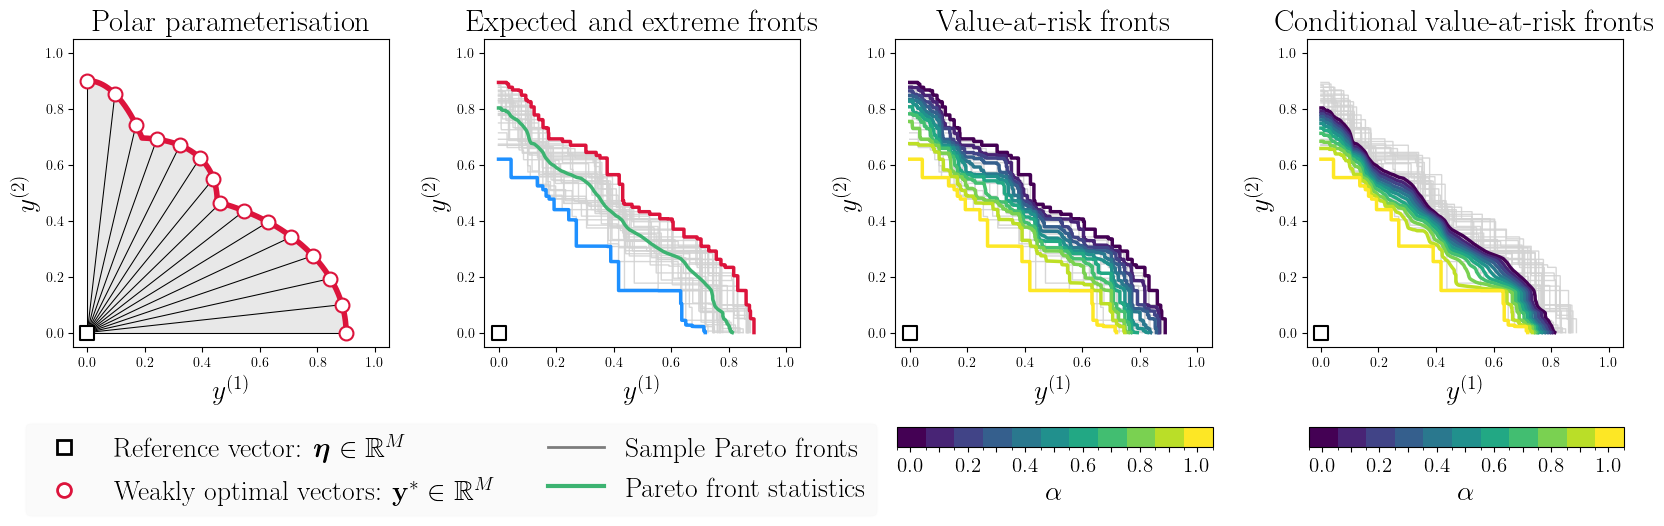

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3
)

for i in range(4):
    ax = plt.subplot(1, 4, i + 1)

    ax.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )

    if i != 0:
        for n in range(num_repeats):
            front = nadir + lengths[n, ...].unsqueeze(-1) * weights
            plt.plot(
                front[:, 0], front[:, 1], color="lightgray", alpha=0.9, linewidth=1
            )

    ax.set_xlabel(r"$y^{(1)}$", fontsize=20)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=20)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

#########################################################################################
# Polar parametrization example.
plt.subplot(1, 4, 1)
plt.plot(p_samples[:, 0], p_samples[:, 1], color="crimson", zorder=5, linewidth=4)
plt.fill_between(
    p_samples[:, 0],
    0 * torch.ones_like(p_samples[:, 0]),
    p_samples[:, 1],
    color="lightgray",
    alpha=0.5,
)
plt.title("Polar parameterisation", fontsize=22)

for i, w in enumerate(example_weights):
    line_i = nadir + example_lengths[i] * t * w
    plt.plot(line_i[:, 0], line_i[:, 1], color="k", alpha=1, linewidth=0.75)
    plt.scatter(
        line_i[-1, 0],
        line_i[-1, 1],
        color="w",
        edgecolors="crimson",
        linewidth=1.5,
        s=100,
        zorder=5,
        alpha=1,
    )
#########################################################################################
# Expectation, min and max.
plt.subplot(1, 4, 2)
plt.plot(
    mean_front[:, 0],
    mean_front[:, 1],
    color="mediumseagreen",
    linestyle="-",
    alpha=1,
    linewidth=2.5,
)
plt.plot(
    min_front[:, 0],
    min_front[:, 1],
    color="dodgerblue",
    linestyle="-",
    alpha=1,
    linewidth=2.5,
)
plt.plot(
    max_front[:, 0],
    max_front[:, 1],
    color="crimson",
    linestyle="-",
    alpha=1,
    linewidth=2.5,
)
plt.title("Expected and extreme fronts", fontsize=22)
#########################################################################################
# Quantiles
plt.subplot(1, 4, 3)
for i, q in enumerate(qs):
    quantile_front = quantile_fronts[q]
    plt.plot(
        quantile_front[:, 0],
        quantile_front[:, 1],
        alpha=1,
        color=q_colors[i],
        linestyle="-",
        linewidth=2.5,
    )
plt.title("Value-at-risk fronts", fontsize=22)

ax_bar = fig.add_axes([0.537, -0.14, 0.158, 0.05])
cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    norm=q_norm,
    spacing="proportional",
    ticks=q_bounds + 0.5,
    boundaries=q_bounds,
    format=FixedFormatter(
        ["0.0", "", "0.2", "", "0.4", "", "0.6", "", "0.8", "", "1.0"]
    ),
    orientation="horizontal",
)
ax_bar.set_xlabel(r"$\alpha$", fontsize=20)
cbar.ax.tick_params(labelsize=15)
#########################################################################################
# CVaR
plt.subplot(1, 4, 4)
for i, q in enumerate(qs):
    cvar_front = cvar_fronts[q]
    plt.plot(
        cvar_front[:, 0],
        cvar_front[:, 1],
        alpha=1,
        color=q_colors[i],
        linestyle="-",
        linewidth=2.5,
    )

plt.title("Conditional value-at-risk fronts", fontsize=22)

ax_bar = fig.add_axes([0.743, -0.14, 0.1575, 0.05])
cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    norm=q_norm,
    spacing="proportional",
    ticks=q_bounds + 0.5,
    boundaries=q_bounds,
    format=FixedFormatter(
        ["0.0", "", "0.2", "", "0.4", "", "0.6", "", "0.8", "", "1.0"]
    ),
    orientation="horizontal",
)
ax_bar.set_xlabel(r"$\alpha$", fontsize=20)
cbar.ax.tick_params(labelsize=15)

#########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
)
red_circle = mlines.Line2D(
    [],
    [],
    color="w",
    marker="o",
    linestyle="None",
    markersize=10,
    markeredgecolor="crimson",
    markeredgewidth=2,
)

gray_line = mlines.Line2D(
    [],
    [],
    color="k",
    linestyle="-",
    alpha=0.5,
    linewidth=2,
)

green_line = mlines.Line2D(
    [],
    [],
    color="mediumseagreen",
    linestyle="-",
    alpha=1.0,
    linewidth=3,
)

axes[0].legend(
    handles=[
        (white_square),
        (red_circle),
        (gray_line),
        (green_line),
    ],
    labels=[
        r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
        r"Weakly optimal vectors: $\mathbf{y}^* \in \mathbb{R}^M$",
        "Sample Pareto fronts",
        "Pareto front statistics",
    ],
    ncol=2,
    fontsize=20,
    loc=(-0.15, -0.55),
    facecolor="k",
    framealpha=0.02,
)

plt.show()